In [14]:
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from result_saver import SaverProvider, metadata_helper, metadata_loader
from soft_info import get_counts, plot_IQ_data
import pandas as pd
import numpy as np

# Generate data

In [4]:
provider = SaverProvider()
backend = provider.get_backend('ibmq_jakarta')

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

qc = QuantumCircuit(1, 1)
#qc.x(0)
qc.measure(0, 0)
print(qc.draw(fold=-1))

initial_layout = [6]
transpiled_qc = transpile(qc, backend, initial_layout=initial_layout)

print(transpiled_qc.draw(fold=-1))

     ┌─┐
  q: ┤M├
     └╥┘
c: 1/═╩═
      0 
                  
ancilla_0 -> 0 ───
                  
ancilla_1 -> 1 ───
                  
ancilla_2 -> 2 ───
                  
ancilla_3 -> 3 ───
                  
ancilla_4 -> 4 ───
                  
ancilla_5 -> 5 ───
               ┌─┐
      q_0 -> 6 ┤M├
               └╥┘
          c: 1/═╩═
                0 


In [5]:
job_metadata = metadata_helper(n_shots=1e6, meas_level=1, sampled_state=0, num_qubits=1, test=True)
job_id = backend.run(job_metadata, transpiled_qc, shots=1e1, meas_level=1, meas_return='single').job_id() 

Custom Warning: updating metadata



In [45]:
data = metadata_loader()
filtered_data = data[data["backend_options"].notna()]
print((filtered_data["backend_options"].to_dict()))
print(filtered_data["backend_options"].to_dict()[17]["meas_level"])


{17: {'shots': 10, 'memory': False, 'meas_level': 1, 'init_qubits': True, 'meas_return': 'single', 'skip_transpilation': True}}
1


In [8]:
job_metadata = metadata_loader()
memories = {}
for i, job_id in enumerate(job_metadata[job_metadata['notebook_name'] == 'KDE_Jak']['job_id']):
    memory_name = 'memory_' + str((i + 1) % 2) + "_state"
    memories[memory_name] = provider.retrieve_job(job_id).result().get_memory()
memories

{'memory_1_state': array([[38845461.-36435344.j],
        [19906178.-41771744.j],
        [10636813.-47942273.j],
        ...,
        [15644804.-45668296.j],
        [38471320.-35815594.j],
        [16732111.-29547949.j]]),
 'memory_0_state': array([[-47030367.-56241506.j],
        [-30773028.-51585687.j],
        [-70253546.-60719018.j],
        ...,
        [-34120294.-81646139.j],
        [-38576581.-35055936.j],
        [ -6236616.-51748192.j]])}

# IQ Plotter

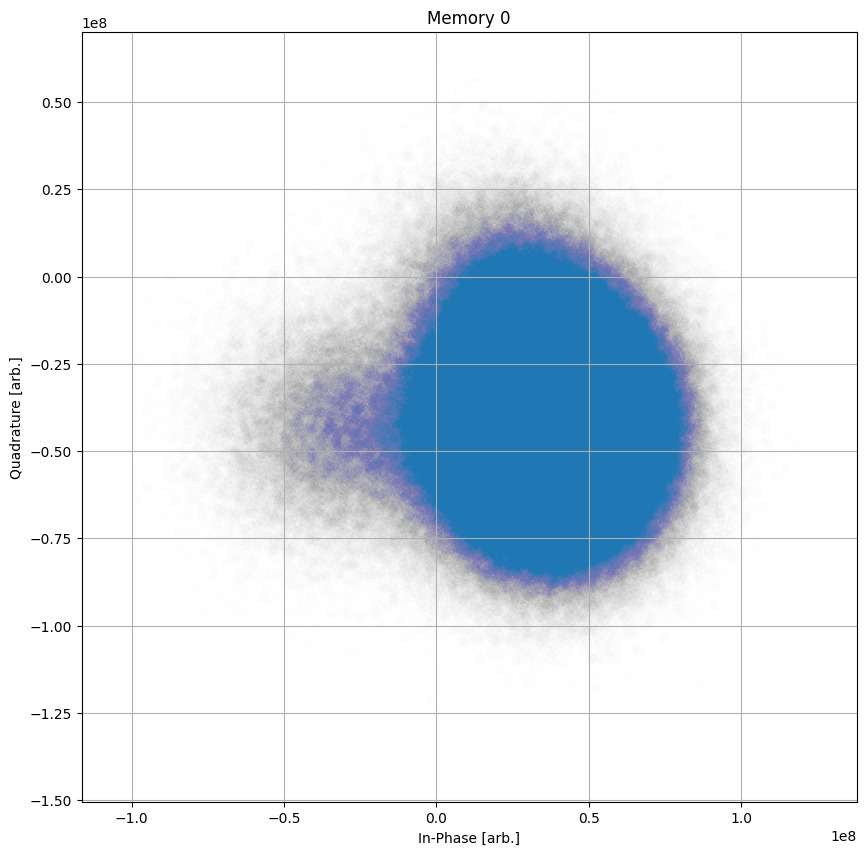

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_complex_numbers(data, title='Complex Numbers Plot'):
    real_parts = np.real(data)
    imag_parts = np.imag(data)

    alpha = min(1, 2e3 / len(data))
    
    plt.figure(figsize=(10, 10))
    plt.scatter(real_parts, imag_parts, alpha=alpha)
    plt.xlabel("In-Phase [arb.]")
    plt.ylabel("Quadrature [arb.]")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_complex_numbers(memories['memory_1_state'][:int(1e6)], title='Memory 0')

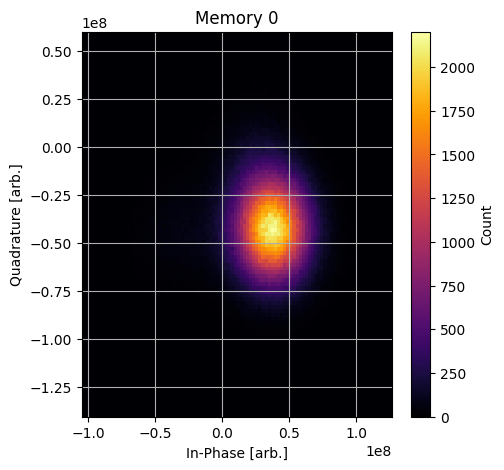

In [18]:
def plot_complex_numbers_heatmap(data, title='Complex Numbers Heatmap', n_bins=100):
    real_parts = np.real(data).flatten()
    imag_parts = np.imag(data).flatten()

    plt.figure(figsize=(5, 5))
    plt.hist2d(real_parts, imag_parts, bins=n_bins, cmap='inferno')
    
    plt.colorbar(label='Count')
    plt.xlabel("In-Phase [arb.]")
    plt.ylabel("Quadrature [arb.]")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_complex_numbers_heatmap(memories['memory_1_state'][:int(1e6)], title='Memory 0')

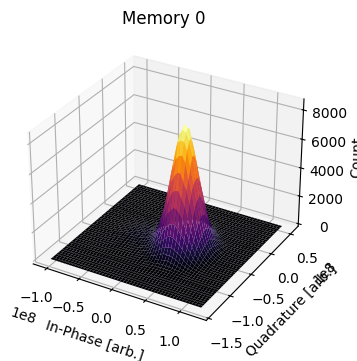

In [21]:
def plot_3D_histogram(data, title='3D Histogram', n_bins=50):
    real_parts = np.real(data).flatten()
    imag_parts = np.imag(data).flatten()

    H, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=n_bins)
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, H.T, cmap='inferno')
    

    ax.set_xlabel('In-Phase [arb.]')
    ax.set_ylabel('Quadrature [arb.]')
    ax.set_zlabel('Count')
    ax.set_title(title)

    plt.show()

plot_3D_histogram(memories['memory_1_state'][:int(1e6)], title='Memory 0')

Custom Warning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.



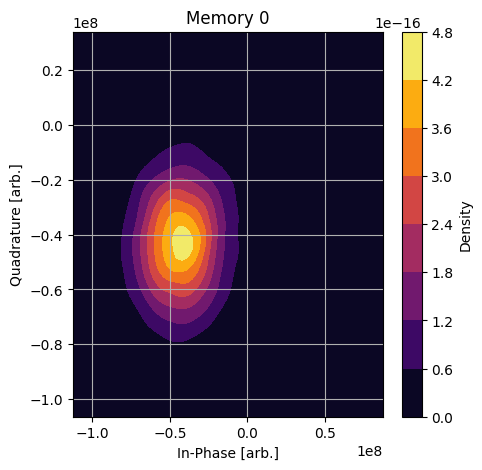

In [13]:
from scipy.stats import kde

def contour_plot(data, title='Contour Plot'):
    real_parts = np.real(data).flatten()
    imag_parts = np.imag(data).flatten()

    # Create grid and multivariate normal
    x, y = np.mgrid[min(real_parts):max(real_parts):100j, min(imag_parts):max(imag_parts):100j]
    positions = np.vstack([x.ravel(), y.ravel()])
    values = np.vstack([real_parts, imag_parts])
    kernel = kde.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, x.shape)

    plt.figure(figsize=(5, 5))
    plt.contourf(x, y, Z, cmap="inferno")
    plt.colorbar(label='Density')
    plt.xlabel("In-Phase [arb.]")
    plt.ylabel("Quadrature [arb.]")
    plt.title(title)
    plt.grid(True)
    plt.show()

contour_plot(memories['memory_0_state'][:int(1e4)], title='Memory 0')


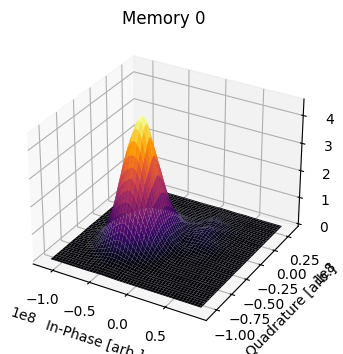

In [14]:
from scipy.stats import gaussian_kde

def plot_3D_surface(data, title='3D Surface Plot', grid_points=100):
    real_parts = np.real(data).flatten()
    imag_parts = np.imag(data).flatten()

    # Create a grid
    x = np.linspace(min(real_parts), max(real_parts), grid_points)
    y = np.linspace(min(imag_parts), max(imag_parts), grid_points)
    x, y = np.meshgrid(x, y)
    grid_coords = np.vstack([x.ravel(), y.ravel()])

    # Perform KDE
    kde = gaussian_kde(np.vstack([real_parts, imag_parts]))
    z = kde(grid_coords).reshape(x.shape)

    # Create the plot
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap='inferno')

    ax.set_xlabel("In-Phase [arb.]")
    ax.set_ylabel("Quadrature [arb.]")
    ax.set_zlabel("Density")
    ax.set_title(title)

    plt.show()

plot_3D_surface(memories['memory_0_state'][:int(1e4)], title='Memory 0')

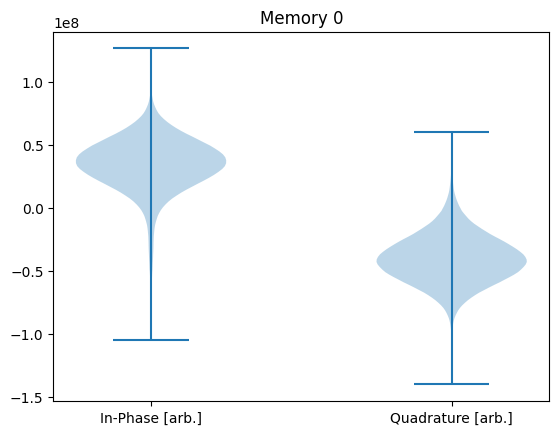

In [22]:
def plot_complex_numbers_violin(data, title='Complex Numbers Violin Plot'):
    real_parts = np.real(data).flatten()
    imag_parts = np.imag(data).flatten()

    fig, ax = plt.subplots()

    ax.violinplot([real_parts, imag_parts])

    ax.set_xticks([1, 2])
    ax.set_xticklabels(['In-Phase [arb.]', 'Quadrature [arb.]'])
    ax.set_title(title)

    plt.show()

plot_complex_numbers_violin(memories['memory_1_state'][:int(1e6)], title='Memory 0')

# Plotter func

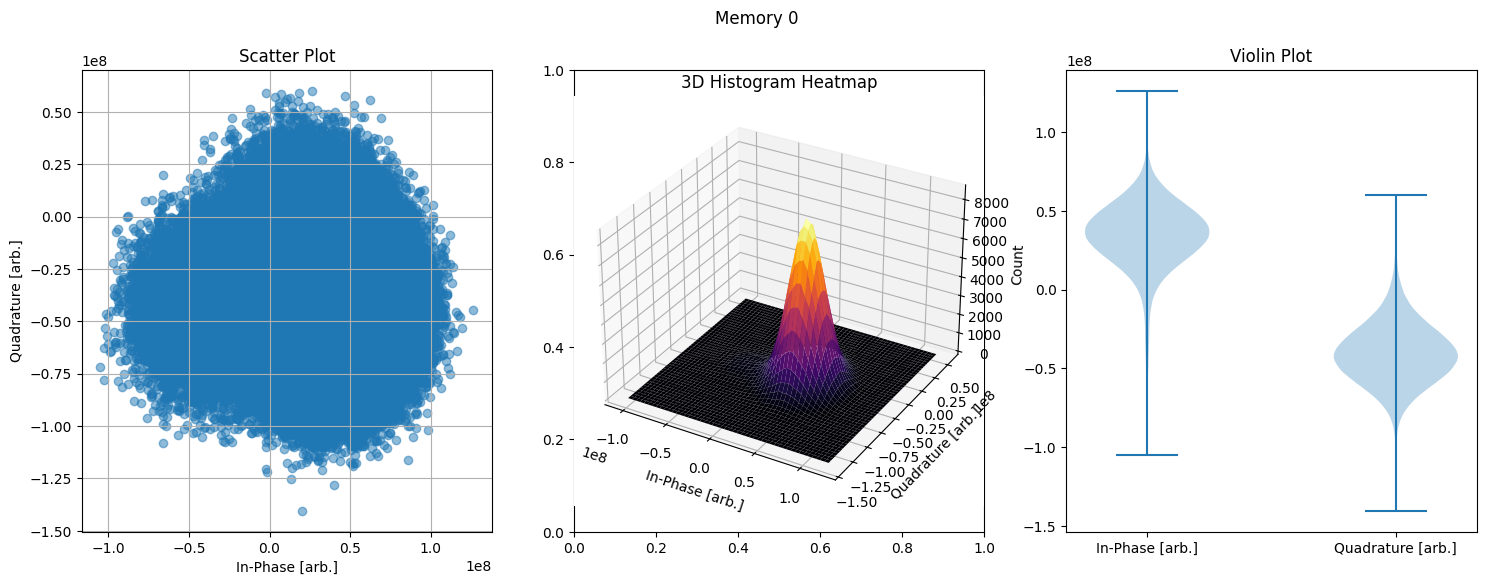

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def plot_complex_numbers_overview(data, title='Complex Numbers Overview', n_bins=50):
    real_parts = np.real(data).flatten()
    imag_parts = np.imag(data).flatten()

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Scatter plot
    axs[0].scatter(real_parts, imag_parts, alpha=0.5)
    axs[0].set_xlabel("In-Phase [arb.]")
    axs[0].set_ylabel("Quadrature [arb.]")
    axs[0].set_title("Scatter Plot")
    axs[0].grid(True)

    # 3D Histogram Heatmap
    H, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=n_bins)
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, Y, H.T, cmap='inferno')
    ax2.set_xlabel("In-Phase [arb.]")
    ax2.set_ylabel("Quadrature [arb.]")
    ax2.set_zlabel("Count")
    ax2.set_title("3D Histogram Heatmap")

    # Violin Plot
    axs[2].violinplot([real_parts, imag_parts])
    axs[2].set_xticks([1, 2])
    axs[2].set_xticklabels(['In-Phase [arb.]', 'Quadrature [arb.]'])
    axs[2].set_title("Violin Plot")

    plt.suptitle(title)
    plt.show()

plot_complex_numbers_overview(memories['memory_1_state'][:int(1e6)], title='Memory 0')

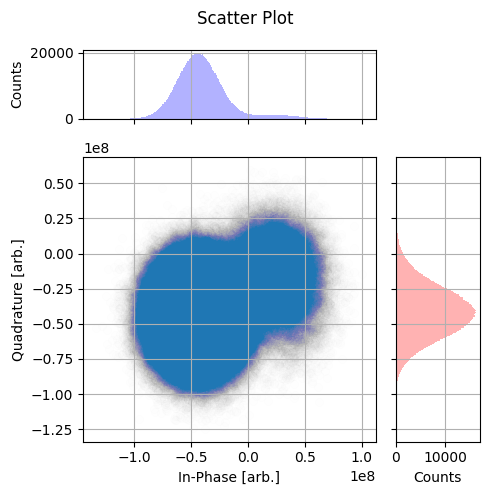

In [120]:
import numpy as np
import matplotlib.pyplot as plt

def plot_complex_numbers_overview(data, title='Complex Numbers Overview', n_bins=250):
    real_parts = np.real(data).flatten()
    imag_parts = np.imag(data).flatten()

    fig = plt.figure(figsize=(5, 5))
    
    # Main scatter plot
    alpha = min(1, 2e3 / len(data))
    ax_scatter = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)
    ax_scatter.scatter(real_parts, imag_parts, alpha=alpha)
    ax_scatter.set_xlabel("In-Phase [arb.]")
    ax_scatter.set_ylabel("Quadrature [arb.]")
    ax_scatter.grid(True)

    # Histogram for the real parts (on the side of scatter plot)
    ax_hist_x = plt.subplot2grid((4, 4), (0, 0), colspan=3, rowspan=1)
    ax_hist_x.hist(real_parts, bins=n_bins, align='mid', color='blue', alpha=0.3)
    ax_hist_x.set_ylabel("Counts")
    ax_hist_x.xaxis.set_ticklabels([])  # Remove x tick labels
    ax_hist_x.grid(True)
    
    # Histogram for the imaginary parts (above the scatter plot)
    ax_hist_y = plt.subplot2grid((4, 4), (1, 3), rowspan=3, colspan=1)
    ax_hist_y.hist(imag_parts, bins=n_bins, orientation='horizontal', align='mid', color='red', alpha=0.3)
    ax_hist_y.set_xlabel("Counts")
    ax_hist_y.yaxis.set_ticklabels([])  # Remove x tick labels
    ax_hist_y.grid(True)

    plt.suptitle("Scatter Plot")
    plt.tight_layout()
    plt.show()

plot_complex_numbers_overview(memories['memory_0_state'][:int(1e6)], title='Memory 0')

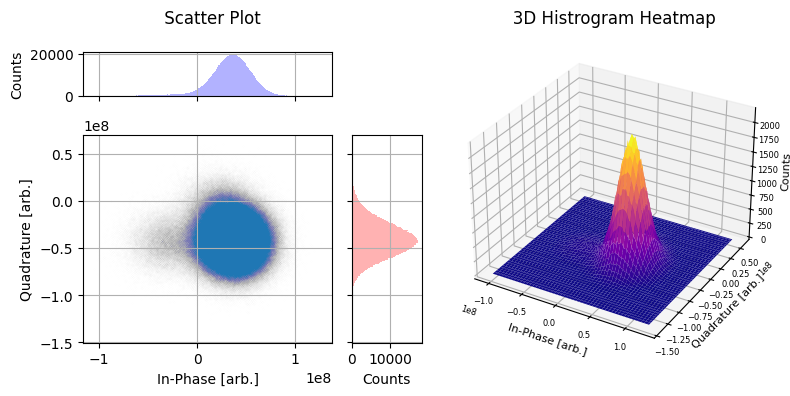

In [231]:
import numpy as np
import matplotlib.pyplot as plt

def plot_complex_numbers_overview(data, title='Complex Numbers Overview', n_bins=250):
    real_parts = np.real(data).flatten()
    imag_parts = np.imag(data).flatten()

    fig = plt.figure(figsize=(8, 4))

    # Main scatter plot
    alpha = min(1, max(2e4/ len(data), 2e-3))
    ax_scatter = plt.subplot2grid((4, 8), (1, 0), rowspan=3, colspan=3)
    ax_scatter.scatter(real_parts, imag_parts, alpha=alpha, marker='.', s=0.1)
    ax_scatter.set_xlabel("In-Phase [arb.]")
    ax_scatter.set_ylabel("Quadrature [arb.]")
    ax_scatter.grid(True)

    # Histogram for the real parts (on the side of scatter plot)
    ax_hist_x = plt.subplot2grid((4, 8), (0, 0), colspan=3, rowspan=1)
    ax_hist_x.hist(real_parts, bins=n_bins, align='mid', color='blue', alpha=0.3)
    ax_hist_x.set_ylabel("Counts")
    ax_hist_x.xaxis.set_ticklabels([])  # Remove x tick labels
    ax_hist_x.grid(True)

    # Histogram for the imaginary parts (above the scatter plot)
    ax_hist_y = plt.subplot2grid((4, 8), (1, 3), rowspan=3, colspan=1)
    ax_hist_y.hist(imag_parts, bins=n_bins, orientation='horizontal', align='mid', color='red', alpha=0.3)
    ax_hist_y.set_xlabel("Counts")
    ax_hist_y.yaxis.set_ticklabels([])  # Remove y tick labels
    ax_hist_y.grid(True)

    # 3D Histogram Heatmap
    H, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=100)
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
    ax3d = plt.subplot2grid((4, 8), (0, 4), rowspan=4, colspan=4, projection='3d')

    ax3d.plot_surface(X, Y, H.T, cmap='plasma')
    
    ax3d.set_xlabel("In-Phase [arb.]", fontsize=8)
    ax3d.set_ylabel("Quadrature [arb.]", fontsize=8)
    ax3d.set_zlabel("Counts", fontsize=8)

    ax3d.tick_params(axis='both', which='major', labelsize=6, pad=-2)
    ax3d.xaxis.offsetText.set_fontsize(6)
    ax3d.yaxis.offsetText.set_fontsize(6)
    ax3d.zaxis.offsetText.set_fontsize(6)

    ax3d.xaxis.labelpad = -7
    ax3d.yaxis.labelpad = -7
    ax3d.zaxis.labelpad = -7

    ax3d.set_box_aspect(None, zoom=1.1)   
    #plt.subplots_adjust(wspace=-1)  # adjust these values as needed

    plt.suptitle("                 Scatter Plot                                                3D Histrogram Heatmap")
    plt.tight_layout()
    plt.show()

# Sample data for demonstration (assuming you have `memories` already defined)
plot_complex_numbers_overview(memories['memory_1_state'][:int(1e6)], title='Memory 0')


# Test the IQ plotter

In [5]:
from qiskit_ibm_provider import IBMProvider

jobibm = IBMProvider().retrieve_job("cmvp9f5421n00081qnng")
jobsav = provider.retrieve_job("cmvp9f5421n00081qnng")


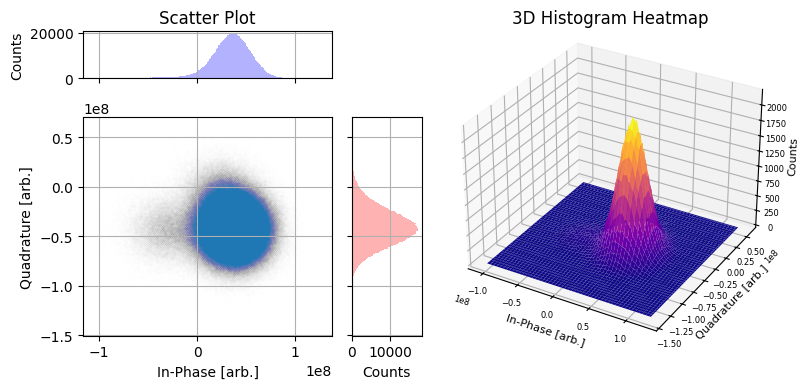

In [17]:
jobsav.plotIQ(n_shots=int(1e6))

# Plot multiple data scatterplots

In [6]:
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from soft_info import plot_multiple_IQ_data

job = provider.retrieve_job("cmvvycsvpdgg008geya0")

data = job.result().get_memory()

Custom Warning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations



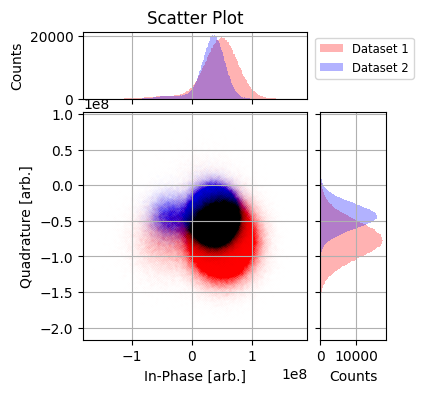

In [8]:
n_shots = int(1e6)
data_qubit_1 = data[:n_shots, 0]
data_qubit_2 = data[:n_shots, 1]
plot_multiple_IQ_data([data_qubit_1, data_qubit_2])

# Analysis

In [29]:
backend = provider.get_backend('ibmq_manila')


qc = QuantumCircuit(2, 2)
qc.x(0)
qc.x(1)
for i in range(20):
    qc.cx(0, 1)
    qc.cx(1, 0)
    qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

initial_layout = [3, 4]
transpiled_qc = transpile(qc, backend, initial_layout=initial_layout, optimization_level=0)
transpiled_qc.draw(fold=-1)



ancilla_0 -> 0 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                                                                                      
ancilla_1 -> 1 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                                                                                      
ancilla_2 -> 2 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               ┌───┐     ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐          ┌───┐     ┌─┐   
      q_0 -> 3 ┤ X ├──■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■────■──┤ X ├──■──┤M├───
               ├───┤┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐└╥┘┌─┐
      q_1 -> 4 ┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├─╫─┤M├
               └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘└───┘     └───┘ ║ └╥┘
          c: 2/══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩═
                                                                                                                                                                                                                                                                                                                                 0  1

In [30]:
job_metadata = metadata_helper(sampled_state = "00", num_qubits=2)
job_id = backend.run(job_metadata, transpiled_qc, shots=1e6, meas_level=1, meas_return='single').job_id()

Custom Warning: updating metadata



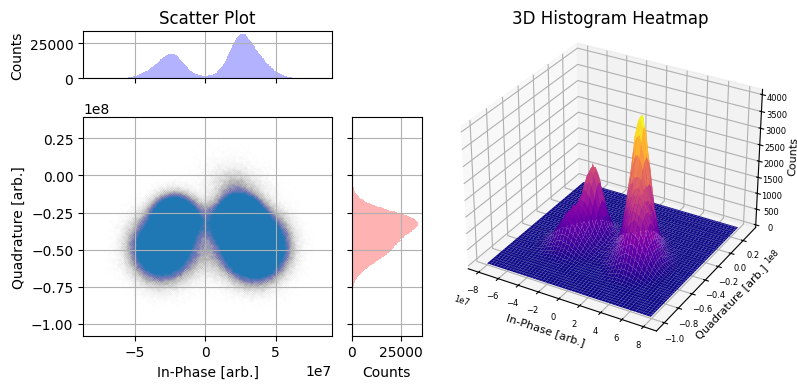

In [9]:
job = provider.retrieve_job("cmvwkbnjad30008ec01g")
job.plotIQ()

Custom Warning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations



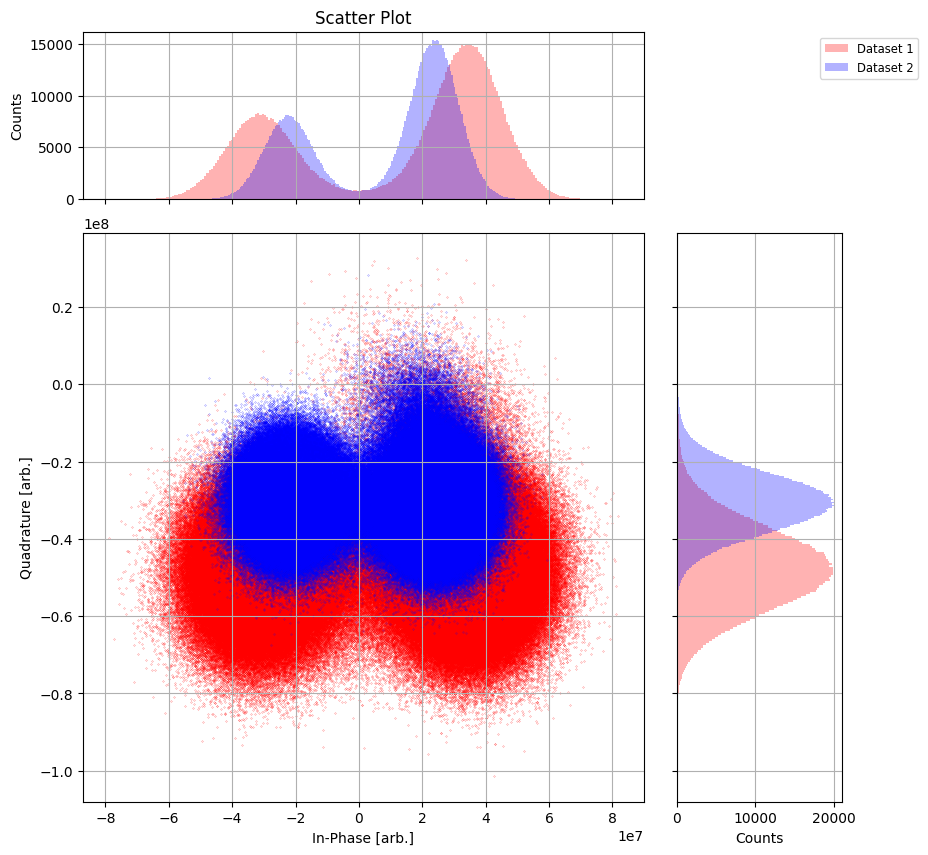

In [16]:
data = job.result().get_memory()
data_qubit_1 = data[:, 0]
data_qubit_2 = data[:, 1]

plot_multiple_IQ_data([data_qubit_1, data_qubit_2], figsize=(20, 10), alpha=1)